# Proyek Machine Learning - Dearmawan
# Rekomendasi Buku

# Import Libraries

In [1]:
# Install library yang diperlukan
!pip install pandas numpy==1.24.4 scikit-learn scikit-surprise matplotlib seaborn pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy
import re
# Mengatur opsi tampilan Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")

Libraries imported successfully!


# Data Load

In [3]:
#Data load
path_books = 'Books.csv'
path_users = 'Users.csv'
path_ratings = 'Ratings.csv'

try:
    books_df = pd.read_csv(path_books, low_memory=False)
    users_df = pd.read_csv(path_users, low_memory=False)
    ratings_df = pd.read_csv(path_ratings, low_memory=False)
except FileNotFoundError:
    print("Pastikan file Books.csv, Users.csv, dan Ratings.csv ada di direktori yang benar atau sesuaikan path.")
print("Shape of books_df:", books_df.shape)
print("Shape of users_df:", users_df.shape)
print("Shape of ratings_df:", ratings_df.shape)

Shape of books_df: (271360, 8)
Shape of users_df: (278858, 3)
Shape of ratings_df: (1149780, 3)


 # Data Understanding

In [4]:
#Book dataset
print("Info books_df:")
books_df.info()
print("\nMissing values in books_df:")
print(books_df.isnull().sum())
print("\nFirst 5 rows of books_df:")
print(books_df.head())
print("\nData types in 'Year-Of-Publication':")
print(books_df['Year-Of-Publication'].unique()[:20]) # Melihat beberapa nilai unik untuk mengecek tipe data

Info books_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB

Missing values in books_df:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

First 5 rows of books_df:
         ISBN  \
0  0195153448   
1  0002005018   
2  0060973129 

Berdasarkan output yang Anda berikan, dataset books_df ini cukup besar dengan lebih dari 270.000 entri buku dan memiliki kelengkapan data yang sangat baik untuk kolom-kolom inti seperti ISBN, Judul Buku, Penulis, dan Penerbit, dengan hanya sedikit sekali nilai yang hilang (masing-masing 2 untuk Penulis dan Penerbit, serta 3 untuk URL gambar besar). Semua kolom saat ini bertipe object, yang mengindikasikan bahwa kolom seperti Year-Of-Publication, meskipun dalam sampel 20 nilai unik pertama tampak seperti tahun (misalnya, '2002', '2001'), perlu dikonversi menjadi tipe numerik untuk analisis lebih lanjut dan mungkin memerlukan pembersihan jika ada entri yang tidak valid di luar sampel tersebut. Kehadiran URL gambar juga memberikan potensi untuk fitur tambahan jika diperlukan, meskipun fokus utama kemungkinan akan pada data tekstual untuk sistem rekomendasi.

In [5]:
# User dataset
print("Info users_df:")
users_df.info()
print("\nMissing values in users_df:")
print(users_df.isnull().sum()) # Banyak nilai Age yang hilang
print("\nFirst 5 rows of users_df:")
print(users_df.head())
print("\nDescriptive statistics for Age:")
print(users_df['Age'].describe())

Info users_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB

Missing values in users_df:
User-ID          0
Location         0
Age         110762
dtype: int64

First 5 rows of users_df:
   User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

Descriptive statistics for Age:
count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.00000

Dataset users_df berisi informasi mengenai 278.858 pengguna, dengan detail mencakup User-ID (integer unik), Location (teks), dan Age (float). Kolom Age menjadi perhatian utama karena memiliki sejumlah besar nilai yang hilang (110.762 data) dan memerlukan pembersihan data akibat adanya nilai yang tidak realistis seperti usia 0 atau 244 tahun, meskipun data usia yang valid menunjukkan rata-rata sekitar 34.75 tahun dan median 32 tahun. Sementara itu, kolom User-ID dan Location tampak lengkap tanpa ada data yang hilang.

In [6]:
# ratings dataset
print("Info ratings_df:")
ratings_df.info()
print("\nMissing values in ratings_df:")
print(ratings_df.isnull().sum())
print("\nFirst 5 rows of ratings_df:")
print(ratings_df.head())
print("\nDescriptive statistics for Book-Rating:")
print(ratings_df['Book-Rating'].describe())
print("\nUnique values in Book-Rating:")
print(sorted(ratings_df['Book-Rating'].unique()))

Info ratings_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB

Missing values in ratings_df:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

First 5 rows of ratings_df:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Descriptive statistics for Book-Rating:
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64

Unique values

Dataset ratings_df sangatlah besar, mencakup lebih dari 1,1 juta entri rating tanpa ada nilai yang hilang pada kolom User-ID, ISBN, maupun Book-Rating. Hal yang paling menonjol dari statistik deskriptif Book-Rating adalah dominasi nilai 0, di mana baik kuartil pertama (25%) maupun median (50%) menunjukkan angka 0. Ini mengindikasikan bahwa sebagian besar entri dalam dataset ini adalah rating implisit atau "tidak ada rating", meskipun skala rating eksplisitnya berkisar dari 1 hingga 10, dengan rata-rata rating keseluruhan sekitar 2.87 dan kuartil ketiga (75%) berada di angka 7.

<ipython-input-7-1ba0601cb1a2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=ratings_df, palette='viridis')


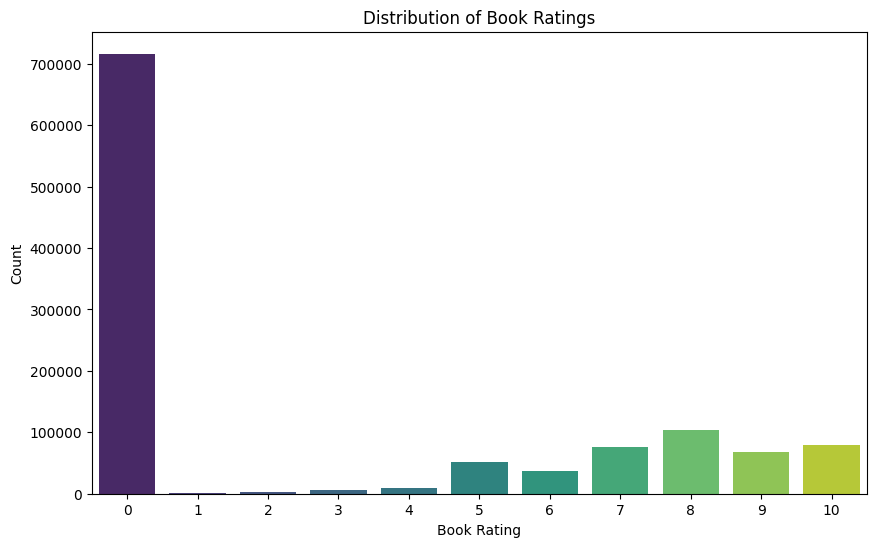

In [7]:
#Visualisasi Distribusi Rating Buku
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=ratings_df, palette='viridis')
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Count')
plt.show()

Visualisasi distribusi rating buku dengan jelas menunjukkan bahwa rating 0 mendominasi secara signifikan, dengan jumlahnya melebihi 700.000, jauh melampaui rating lainnya. Rating eksplisit (1-10) memiliki frekuensi yang jauh lebih rendah, dengan rating 8, 9, dan 10 menjadi yang paling banyak diberikan di antara rating eksplisit tersebut, meskipun jumlahnya masih di bawah 100.000 masing-masing. Ini mengindikasikan bahwa sebagian besar interaksi dalam dataset adalah implisit atau "tidak ada rating", dan untuk analisis yang melibatkan preferensi eksplisit, fokus pada rating 1-10 akan lebih relevan, dengan perhatian khusus pada rating tinggi (7-10) yang menunjukkan sentimen positif yang lebih kuat.

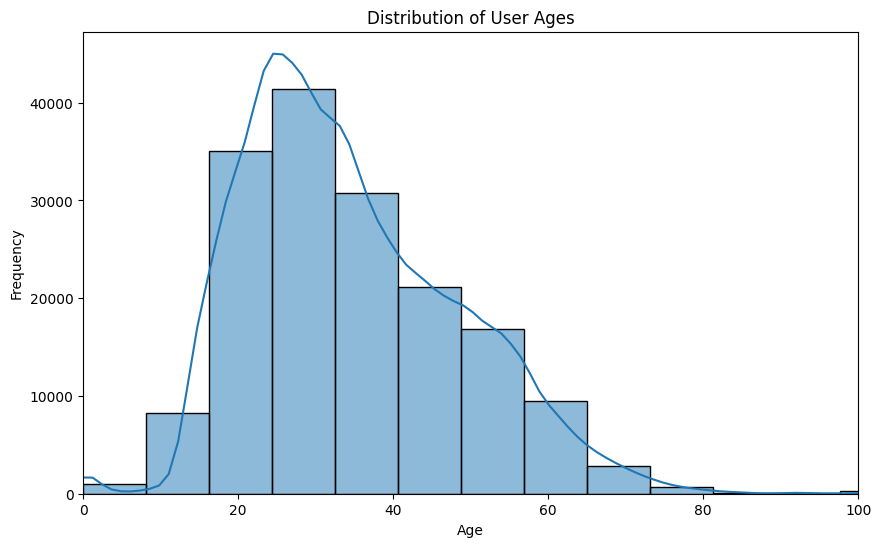

In [8]:
# Visualisai Distribusi Usia Pengguna
plt.figure(figsize=(10,6))
sns.histplot(users_df['Age'].dropna(), bins=30, kde=True)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.xlim(0, 100) # Batasi usia agar lebih relevan
plt.show()

Berdasarkan histogram distribusi usia pengguna, terlihat bahwa mayoritas pengguna berada dalam rentang usia muda hingga paruh baya, dengan puncaknya di sekitar usia 30-an. Distribusi ini cenderung miring ke kanan (right-skewed), menunjukkan bahwa meskipun ada pengguna di berbagai kelompok usia hingga sekitar 80-an, jumlah mereka menurun drastis setelah usia 40-an, mengindikasikan basis pengguna yang kuat pada demografi yang lebih muda.

<ipython-input-9-e09c928d5d1f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_rated_books.values, y=top_10_rated_books.index, palette='mako')


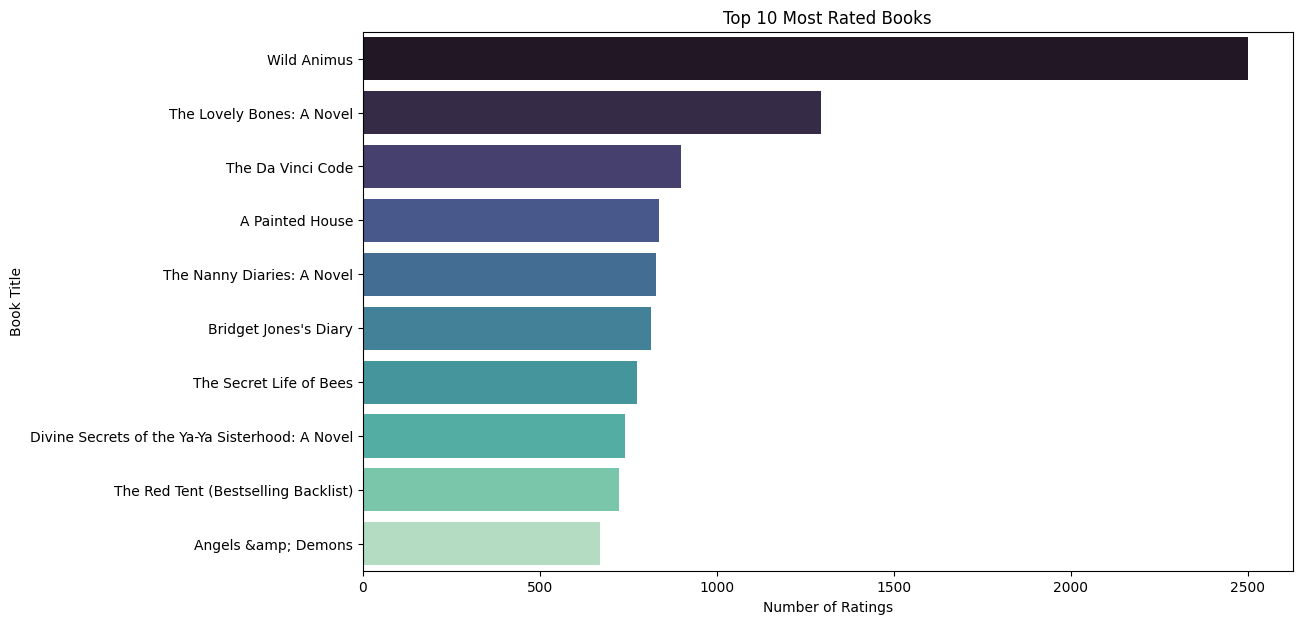

In [9]:
# visualisai Top 10 Buku dengan Ratings Count Terbanyak
# Gabungkan ratings dengan books untuk mendapatkan judul buku
ratings_with_titles = ratings_df.merge(books_df[['ISBN', 'Book-Title']], on='ISBN')

top_10_rated_books = ratings_with_titles['Book-Title'].value_counts().head(10)
plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_rated_books.values, y=top_10_rated_books.index, palette='mako')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

Grafik menunjukkan bahwa buku "Wild Animus" memiliki jumlah rating yang jauh melampaui buku-buku lain dalam daftar 10 teratas, menandakan popularitas atau jumlah interaksi yang sangat tinggi dibandingkan dengan judul-judul lain seperti "The Lovely Bones: A Novel" atau "The Da Vinci Code" yang berada di posisi berikutnya. Meskipun semua buku dalam daftar ini masuk dalam kategori paling banyak diberi rating, ada jurang pemisah yang signifikan antara posisi pertama dengan sembilan buku lainnya, menunjukkan dominasi "Wild Animus" dalam hal jumlah rating yang diterima.

#Data Preparation

In [10]:
# Persiapan data book
# --- Persiapan books_df ---
print("Original unique 'Year-Of-Publication' examples:", books_df['Year-Of-Publication'].unique()[:5])
# Koreksi 'Year-Of-Publication'
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')
# Isi NaN dengan nilai yang tidak mungkin mempengaruhi analisis, atau drop jika sedikit. Kita isi dengan median tahun yang valid.
median_year = books_df['Year-Of-Publication'].median()
books_df['Year-Of-Publication'].fillna(median_year, inplace=True)
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

# Isi NaN pada Book-Author dan Publisher
books_df['Book-Author'].fillna('Unknown Author', inplace=True)
books_df['Publisher'].fillna('Unknown Publisher', inplace=True)

# Drop kolom URL gambar karena tidak akan digunakan
books_df.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], inplace=True, errors='ignore')

print("\nInfo books_df after cleaning:")
books_df.info()
print("\nMissing values in books_df after cleaning:")
print(books_df.isnull().sum())

Original unique 'Year-Of-Publication' examples: ['2002' '2001' '1991' '1999' '2000']

Info books_df after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271360 non-null  int64 
 4   Publisher            271360 non-null  object
dtypes: int64(1), object(4)
memory usage: 10.4+ MB

Missing values in books_df after cleaning:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64


<ipython-input-10-95d78f01e51c>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_df['Year-Of-Publication'].fillna(median_year, inplace=True)
<ipython-input-10-95d78f01e51c>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Dapat dilihat sudah dilakukan penaganan missing value dan drop kolom yang tidak perlu sehingga data memiliki jumlah yg sama untuk dataset book

In [11]:
# Persiaoan dataset users
# --- Persiapan users_df ---
# Menangani outliers dan NaN pada Age
users_df.loc[(users_df['Age'] > 90) | (users_df['Age'] < 5), 'Age'] = np.nan
users_df['Age'].fillna(users_df['Age'].median(), inplace=True)
users_df['Age'] = users_df['Age'].astype(int)

print("\nInfo users_df after cleaning:")
users_df.info()
print("\nMissing values in users_df after cleaning:")
print(users_df.isnull().sum())



<ipython-input-11-4477488c9928>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users_df['Age'].fillna(users_df['Age'].median(), inplace=True)



Info users_df after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       278858 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.4+ MB

Missing values in users_df after cleaning:
User-ID     0
Location    0
Age         0
dtype: int64


Dapat dilihat outlier sudah diatasi dan tidak adanya missing value.

In [12]:
# Persiapan dataset ratings
# --- Persiapan ratings_df ---
# Untuk Content-Based, kita hanya perlu books_df yang sudah bersih.
# Untuk Collaborative Filtering, kita perlu ratings_df dan users_df.

# Filter rating eksplisit untuk Collaborative Filtering
ratings_explicit_df = ratings_df[ratings_df['Book-Rating'] != 0]
print(f"\nOriginal ratings: {len(ratings_df)}, Explicit ratings: {len(ratings_explicit_df)}")

# Gabungkan dengan informasi buku untuk kemudahan
full_data_explicit = ratings_explicit_df.merge(books_df[['ISBN', 'Book-Title']], on='ISBN')
full_data_explicit = full_data_explicit.merge(users_df[['User-ID', 'Age']], on='User-ID') # Tambahkan age jika diperlukan

print("\nFirst 5 rows of merged explicit ratings data:")
print(full_data_explicit.head())


Original ratings: 1149780, Explicit ratings: 433671

First 5 rows of merged explicit ratings data:
   User-ID        ISBN  Book-Rating  \
0   276726  0155061224            5   
1   276729  052165615X            3   
2   276729  0521795028            6   
3   276744  038550120X            7   
4   276747  0060517794            9   

                                                       Book-Title  Age  
0                                                Rites of Passage   32  
1                                                  Help!: Level 1   16  
2  The Amsterdam Connection : Level 4 (Cambridge English Readers)   16  
3                                                 A Painted House   32  
4                                        Little Altars Everywhere   25  


Ini memberikan gambaran awal tentang data rating buku yang digunakan, menunjukkan bahwa dari total 1,149,780 original ratings, hanya 433,671 yang merupakan explicit ratings yang dapat digunakan untuk analisis atau pelatihan model yang membutuhkan nilai rating spesifik. Tampilan beberapa baris pertama dari data explicit ratings yang sudah digabungkan memperlihatkan struktur datanya, meliputi User-ID, ISBN, nilai Book-Rating, judul buku (Book-Title), dan usia pengguna (Age), menegaskan ketersediaan informasi penting ini untuk memahami perilaku pengguna dalam memberikan rating dan karakteristik demografi mereka terkait dengan buku yang dinilai.

In [13]:
# --- Filtering untuk Collaborative Filtering (mengurangi sparsity) ---
# Pertimbangkan pengguna yang memberi setidaknya N rating dan buku yang menerima setidaknya M rating
min_ratings_user = 5 # Contoh threshold
user_counts = full_data_explicit['User-ID'].value_counts()
active_users = user_counts[user_counts >= min_ratings_user].index
filtered_ratings_cf = full_data_explicit[full_data_explicit['User-ID'].isin(active_users)]

min_ratings_book = 5 # Contoh threshold
book_counts = filtered_ratings_cf['ISBN'].value_counts()
popular_books = book_counts[book_counts >= min_ratings_book].index
filtered_ratings_cf = filtered_ratings_cf[filtered_ratings_cf['ISBN'].isin(popular_books)]

print(f"\nShape of filtered_ratings_cf for Collaborative Filtering: {filtered_ratings_cf.shape}")
if filtered_ratings_cf.empty:
    print("WARNING: filtered_ratings_cf is empty. Thresholds for filtering might be too high or data is too sparse.")
else:
    print("Filtered ratings for CF are ready.")


Shape of filtered_ratings_cf for Collaborative Filtering: (135310, 5)
Filtered ratings for CF are ready.


mengindikasikan bahwa proses pemfilteran data rating telah berhasil diselesaikan untuk keperluan Collaborative Filtering, menghasilkan dataset siap pakai yang diberi nama filtered_ratings_cf. Dataset ini memiliki dimensi (135310, 5), yang berarti terdiri dari 135.310 baris data (kemungkinan merepresentasikan interaksi pengguna-buku berupa rating) dengan 5 kolom atribut (seperti User-ID, ISBN, Rating, dll.), yang kini siap digunakan untuk melatih atau mengaplikasikan model rekomendasi berbasis kolaborasi

# Modeling  Content-Based Filtering

In [14]:
# --- Content-Based Filtering ---
from sklearn.metrics.pairwise import linear_kernel # Atau cosine_similarity jika mau
sample_fraction = 0.1 # Ambil 10% data (sekitar 27rb buku), sesuaikan sesuai kebutuhan/kemampuan RAM
# Atau gunakan jumlah absolut: sample_size = 20000
print(f"Taking a sample of {sample_fraction*100}% of the books for faster processing...")
books_cb_sample = books_df.sample(frac=sample_fraction, random_state=42).copy()
# -----------------------------------------------------

# Gunakan 'books_cb_sample' di langkah selanjutnya
books_cb_sample.fillna('', inplace=True)
books_cb_sample['content'] = books_cb_sample['Book-Title'] + ' ' + books_cb_sample['Book-Author'] + ' ' + books_cb_sample['Publisher']

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

# Membuat matriks TF-IDF dari SAMPEL
print("Fitting TF-IDF on sample...")
tfidf_matrix_sample = tfidf.fit_transform(books_cb_sample['content'])
print("Shape of TF-IDF matrix (sample):", tfidf_matrix_sample.shape)

# Menghitung KEMIRIPAN pada SAMPEL
print("Calculating similarity on sample using linear_kernel...")
cosine_sim_cb_sample = linear_kernel(tfidf_matrix_sample, tfidf_matrix_sample)
# Atau: cosine_sim_cb_sample = cosine_similarity(tfidf_matrix_sample, tfidf_matrix_sample)
print("Shape of Similarity matrix (sample):", cosine_sim_cb_sample.shape)

# Membuat mapping dari ISBN ke Indeks untuk SAMPEL
books_cb_sample.reset_index(drop=True, inplace=True) # Reset index sample
indices_cb_sample = pd.Series(books_cb_sample.index, index=books_cb_sample['ISBN']).drop_duplicates()

# Fungsi untuk mendapatkan rekomendasi (disesuaikan untuk sampel)
def get_content_based_recommendations_sample(isbn, N=10):
    if isbn not in indices_cb_sample:
        return f"ISBN {isbn} not found in the sample's unique ISBN list."

    try:
      idx = indices_cb_sample[isbn]
      if isinstance(idx, pd.Series): idx = idx.iloc[0]
    except KeyError:
        return f"ISBN {isbn} not found in the sample indices mapping."
    except Exception as e:
        return f"Error finding index for sample ISBN {isbn}: {e}"

    sim_scores = list(enumerate(cosine_sim_cb_sample[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    book_indices = [i[0] for i in sim_scores]

    # Kembalikan N buku paling mirip dari SAMPEL
    recommended_books = books_cb_sample.iloc[book_indices][['ISBN', 'Book-Title', 'Book-Author']]
    recommended_books['similarity_score'] = [s[1] for s in sim_scores]
    return recommended_books

# Contoh penggunaan Content-Based Filtering pada SAMPEL
if not books_cb_sample.empty:
    # Cari ISBN contoh yang ADA di dalam sampel
    try:
        sample_isbn_cb_in_sample = books_cb_sample['ISBN'].iloc[0]
        sample_title_in_sample = books_cb_sample.loc[books_cb_sample['ISBN'] == sample_isbn_cb_in_sample, 'Book-Title'].values[0]
        print(f"\nRecommendations for book (from sample) with ISBN: {sample_isbn_cb_in_sample} ('{sample_title_in_sample}')")
        recommendations_cb_s = get_content_based_recommendations_sample(sample_isbn_cb_in_sample, N=5)
        print(recommendations_cb_s)
    except IndexError:
        print("\nSample dataframe is empty, cannot get sample ISBN.")
else:
    print("books_cb_sample dataframe is empty. Cannot provide recommendations.")

Taking a sample of 10.0% of the books for faster processing...
Fitting TF-IDF on sample...
Shape of TF-IDF matrix (sample): (27136, 176829)
Calculating similarity on sample using linear_kernel...
Shape of Similarity matrix (sample): (27136, 27136)

Recommendations for book (from sample) with ISBN: 0679764275 ('The F Word')
             ISBN                                                  Book-Title  \
19535  0375407413                   Random House Webster's College Dictionary   
22905  0679780114    Random House Webster's American Sign Language Dictionary   
8505   0679408797                                                 Conglomeros   
19407  0394487028                                                        Hers   
15419  0394840909  I Can Count to 100 ... Can You? (Random House Pictureback)   

                  Book-Author  similarity_score  
19535            Random House          0.380672  
22905  Elaine, Ph.D. Costello          0.290939  
8505            Jesse Browner         

Output ini menunjukkan proses dan hasil dari sistem rekomendasi berbasis konten (content-based recommendation system) yang diterapkan pada dataset buku, khususnya untuk merekomendasikan buku-buku yang mirip dengan buku berjudul "'The F Word'". Sistem ini menggunakan sampel 10% dari data buku, menghitung kesamaan antar buku menggunakan representasi TF-IDF dan kernel linear, kemudian menghasilkan daftar buku rekomendasi bersama dengan skor kesamaan. Hasilnya menunjukkan beberapa buku yang direkomendasikan beserta detailnya, dengan skor kesamaan yang bervariasi, mencerminkan seberapa mirip konten buku-buku tersebut berdasarkan analisis tekstual oleh sistem.

# Modeling Collaborative Filtering

In [15]:
# --- Collaborative Filtering ---
# Menggunakan filtered_ratings_cf yang sudah dipersiapkan
if filtered_ratings_cf.empty:
    print("Skipping Collaborative Filtering due to empty filtered_ratings_cf.")
else:
    # Persiapan data untuk Surprise
    reader = Reader(rating_scale=(1, 10)) # Rating eksplisit dari 1 hingga 10
    data_cf = Dataset.load_from_df(filtered_ratings_cf[['User-ID', 'ISBN', 'Book-Rating']], reader)

    # Split data menjadi train dan test set
    trainset_cf, testset_cf = surprise_train_test_split(data_cf, test_size=0.2, random_state=42)

    # Menggunakan SVD
    algo_svd = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42) # Parameter bisa di-tune
    print("\nTraining SVD model...")
    algo_svd.fit(trainset_cf)
    print("SVD model trained.")

    # Membuat prediksi pada test set
    predictions_svd = algo_svd.test(testset_cf)

    # Evaluasi model (RMSE dan MAE)
    rmse_svd = accuracy.rmse(predictions_svd)
    mae_svd = accuracy.mae(predictions_svd)
    print(f"SVD - RMSE: {rmse_svd}")
    print(f"SVD - MAE: {mae_svd}")

    # Fungsi untuk mendapatkan top-N rekomendasi untuk pengguna
    def get_collaborative_filtering_recommendations(user_id, N=10):
        # Dapatkan daftar semua ISBN yang belum dirating oleh pengguna
        rated_isbns = filtered_ratings_cf[filtered_ratings_cf['User-ID'] == user_id]['ISBN'].unique()
        all_isbns = filtered_ratings_cf['ISBN'].unique()
        unrated_isbns = [isbn for isbn in all_isbns if isbn not in rated_isbns]

        if not unrated_isbns:
            return "User has rated all available books or no unrated books found for this user in the filtered set."

        # Prediksi rating untuk buku yang belum dirating
        test_set_for_user = [[user_id, isbn, 0] for isbn in unrated_isbns] # 0 adalah placeholder
        predictions = algo_svd.test(test_set_for_user)

        predictions.sort(key=lambda x: x.est, reverse=True) # Urutkan berdasarkan estimasi rating

        top_n_predictions = predictions[:N]

        # Dapatkan detail buku untuk rekomendasi
        recommended_book_isbns = [pred.iid for pred in top_n_predictions]
        recommended_book_details = books_df[books_df['ISBN'].isin(recommended_book_isbns)][['ISBN', 'Book-Title', 'Book-Author']]

        # Tambahkan estimasi rating
        # Perlu mencocokkan kembali karena urutan bisa berubah jika ada ISBN duplikat atau tidak ditemukan
        est_ratings_map = {pred.iid: pred.est for pred in top_n_predictions}
        recommended_book_details['estimated_rating'] = recommended_book_details['ISBN'].map(est_ratings_map)

        # Urutkan berdasarkan estimasi rating lagi setelah merge
        recommended_book_details = recommended_book_details.sort_values(by='estimated_rating', ascending=False).reset_index(drop=True)

        return recommended_book_details

    # Contoh penggunaan Collaborative Filtering
    if not filtered_ratings_cf.empty:
        # Ambil User-ID contoh dari dataset yang difilter
        sample_user_id_cf = filtered_ratings_cf['User-ID'].unique()[0]
        print(f"\nRecommendations for User-ID: {sample_user_id_cf} using SVD")
        recommendations_cf = get_collaborative_filtering_recommendations(sample_user_id_cf, N=5)
        print(recommendations_cf)
    else:
        print("filtered_ratings_cf is empty. Cannot provide CF recommendations.")


Training SVD model...
SVD model trained.
RMSE: 1.5741
MAE:  1.2101
SVD - RMSE: 1.5741099850201379
SVD - MAE: 1.2101231606905607

Recommendations for User-ID: 276747 using SVD
         ISBN                                             Book-Title  \
0  0743454529           My Sister's Keeper : A Novel (Picoult, Jodi)   
1  0812550706          Ender's Game (Ender Wiggins Saga (Paperback))   
2  0439136369      Harry Potter and the Prisoner of Azkaban (Book 3)   
3  0836213319                           Dilbert: A Book of Postcards   
4  0439425220  Harry Potter and the Chamber of Secrets Postcard Book   

        Book-Author  estimated_rating  
0      Jodi Picoult          9.540725  
1  Orson Scott Card          9.432904  
2     J. K. Rowling          9.430569  
3       Scott Adams          9.373584  
4     J. K. Rowling          9.369498  


Menampilkan hasil dari penerapan model Singular Value Decomposition (SVD) untuk sistem rekomendasi, kemungkinan besar menggunakan pendekatan collaborative filtering. Setelah model SVD dilatih, kinerjanya dievaluasi menggunakan metrik RMSE sebesar 1.574 dan MAE sebesar 1.210, yang mengindikasikan tingkat kesalahan prediksi rating. Selanjutnya, sistem ini memberikan rekomendasi buku yang dipersonalisasi untuk Pengguna dengan ID 276747, menyajikan daftar buku beserta perkiraan rating (estimated_rating) yang menunjukkan seberapa besar kemungkinan pengguna tersebut akan menyukai buku-buku yang direkomendasikan berdasarkan pola rating dari pengguna lain.

# Evaluation Content-Based Filtering

In [19]:
# --- Evaluasi Content-Based Filtering (Sangat Sederhana - Inspeksi Visual) ---

print("\n--- Evaluasi Content-Based Filtering (Sangat Sederhana) ---")

# Catatan: Ini adalah inspeksi visual/kualitatif.
# Anda perlu melihat hasilnya dan menilai sendiri relevansinya.

if not books_cb_sample.empty:
    # Pilih satu buku acak dari sampel untuk diuji
    try:
        random_book_in_sample = books_cb_sample.sample(1, random_state=42).iloc[0]
        isbn_to_test_simple = random_book_in_sample['ISBN']
        title_to_test_simple = random_book_in_sample['Book-Title']

        print(f"\nMeminta rekomendasi untuk buku (dari sampel):")
        print(f"ISBN: {isbn_to_test_simple}")
        print(f"Judul: '{title_to_test_simple}'")

        # Dapatkan rekomendasi menggunakan fungsi yang sudah ada
        recommendations_simple = get_content_based_recommendations_sample(isbn_to_test_simple, N=10)

        # Tampilkan hasil rekomendasi
        if isinstance(recommendations_simple, pd.DataFrame):
            print("\nRekomendasi Teratas:")
            print(recommendations_simple)
            print("\n(Periksa apakah buku-buku di atas terlihat mirip dengan buku input)")
        else:
            # Menangani kasus jika ISBN tidak ditemukan di sampel
            print(recommendations_simple)

    except Exception as e:
        print(f"Terjadi error saat mencoba mendapatkan rekomendasi untuk sampel acak: {e}")

else:
    print("Dataframe sample (books_cb_sample) kosong, tidak bisa melakukan evaluasi sederhana.")

# --- Akhir Bagian Evaluasi Sederhana ---


--- Evaluasi Content-Based Filtering (Sangat Sederhana) ---

Meminta rekomendasi untuk buku (dari sampel):
ISBN: 038548755X
Judul: 'Enterprise One to One: Tools for Competing in the Interactive Age'

Rekomendasi Teratas:
             ISBN  \
8969   0385494092   
11157  038549369X   
26088  0679790756   
16170  0385420579   
8037   0440425050   
10711  0609608002   
5192   0448058081   
4152   059042520x   
22816  0385421540   
25547  0201144689   

                                                                                                  Book-Title  \
8969         One to One B2B: Customer Development Strategies for the Business-To-Business World (One to One)   
11157  The One to One Fieldbook: The Complete Toolkit for Implementing a 1To1 Marketing Program (One to One)   
26088                                      Windows 3.1 Power Tools/Book and Disk (Bantam Power Tools Series)   
16170                                                                                    The Repub

Menyajikan evaluasi dari sistem content-based filtering yang sederhana, di mana sistem memberikan rekomendasi buku berdasarkan kesamaan konten dengan buku input "Enterprise One to One: Tools for Competing in the Interactive Age". Hasilnya menampilkan daftar buku yang direkomendasikan beserta skor kesamaan mereka. Meskipun beberapa judul yang direkomendasikan seperti "One to One B2B" dan "The One to One Fieldbook" secara tematis terlihat terkait, skor kesamaan yang relatif rendah (di bawah 0.3) untuk sebagian besar rekomendasi menunjukkan bahwa metode analisis konten atau perhitungan kesamaan yang digunakan mungkin perlu ditingkatkan untuk menghasilkan rekomendasi yang lebih relevan atau serupa secara kuat.

# Evaluation Collaborative Filtering




In [18]:
# Hasil evaluasi SVD sudah dicetak sebelumnya saat training
if 'rmse_svd' in globals() and 'mae_svd' in globals():
    print("\n--- Evaluation Metrics for Collaborative Filtering (SVD) ---")
    print(f"SVD Model - RMSE: {rmse_svd:.4f}")
    print(f"SVD Model - MAE: {mae_svd:.4f}")
    print("\nInterpretasi:")
    print(f"RMSE sebesar {rmse_svd:.4f} menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar {rmse_svd:.4f} poin rating dari rating sebenarnya, dengan kesalahan yang lebih besar diberi bobot lebih.")
    print(f"MAE sebesar {mae_svd:.4f} menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar {mae_svd:.4f} poin rating dari rating sebenarnya.")
    print("Nilai ini perlu dipertimbangkan dalam konteks skala rating (1-10). Semakin rendah, semakin baik performa model dalam memprediksi rating.")
else:
    print("\nSkipping CF evaluation as SVD model results are not available (likely due to empty filtered_ratings_cf).")



--- Evaluation Metrics for Collaborative Filtering (SVD) ---
SVD Model - RMSE: 1.5741
SVD Model - MAE: 1.2101

Interpretasi:
RMSE sebesar 1.5741 menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar 1.5741 poin rating dari rating sebenarnya, dengan kesalahan yang lebih besar diberi bobot lebih.
MAE sebesar 1.2101 menunjukkan bahwa rata-rata, prediksi rating model SVD kita menyimpang sekitar 1.2101 poin rating dari rating sebenarnya.
Nilai ini perlu dipertimbangkan dalam konteks skala rating (1-10). Semakin rendah, semakin baik performa model dalam memprediksi rating.



Menyajikan metrik evaluasi untuk model Collaborative Filtering menggunakan metode SVD, dengan nilai RMSE sebesar 1.5741 dan MAE sebesar 1.2101. Nilai-nilai ini mengindikasikan performa model dalam memprediksi rating pengguna; secara rata-rata, prediksi rating model SVD menyimpang sekitar 1.5741 poin dari rating sebenarnya (dengan penalti lebih besar untuk kesalahan besar) dan memiliki rata-rata selisih absolut 1.2101 poin dari rating sebenarnya. Dalam konteks skala rating 1-10, semakin rendah nilai RMSE dan MAE, semakin baik kemampuan model dalam memprediksi rating, sehingga nilai-nilai ini memberikan gambaran kuantitatif tentang akurasi rekomendasi yang dihasilkan oleh model SVD ini.